This notebook steps throgh how to implement an image recognition model using a convolutional network.  You will start with a basic CNN architecture to classify fashion from the Fashion MNIST data set found here:  https://github.com/zalandoresearch/fashion-mnist. The data set consists of 10,000 clothing items classified into 10 categories.
    
There are optional steps in the notebook to demonstrate use of more advanced network features. The model is built using Keras and Tensorflow and assumes you are runnig on a Databricks cluter with ML and DL frameworks and libraries pre-installed. 

This notebook is adapted from work published here:(1) https://github.com/amynic/azureml-sdk-fashion and (2) https://github.com/Microsoft/CNTK/tree/v2.0/Tutorials.

In [2]:
import tensorflow as tf
import os
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K
print(os.environ['KERAS_BACKEND'])

tensorflow Version is: 1.12.0
tensorflow

In [3]:
# Import the required Keras functions that will be used to create the CNN
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils, losses, optimizers
import matplotlib.pyplot as plt

The fasion MNIST data set is included with the Keras library so we need to pull it into a training and test datasets.  The dataset consists of 60,000 training images and 10,000 test images.  Each image is associated with a label from 10 classifications: 
Label    Description
0        T-shirt/top
1        Trouser
2        Pullover
3        Dress
4        Coat
5        Sandal
6        Shirt
7        Sneaker
8        Bag
9        Ankle boot

In [5]:
#data for train and testing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, 'train set')
print(x_test.shape, 'test set')

# Define the text labels
fashion_mnist_labels = ["Top",          # index 0
                        "Trouser",      # index 1
                        "Jumper",       # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Trainer",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9



(60000, 28, 28) train set
(10000, 28, 28) test set

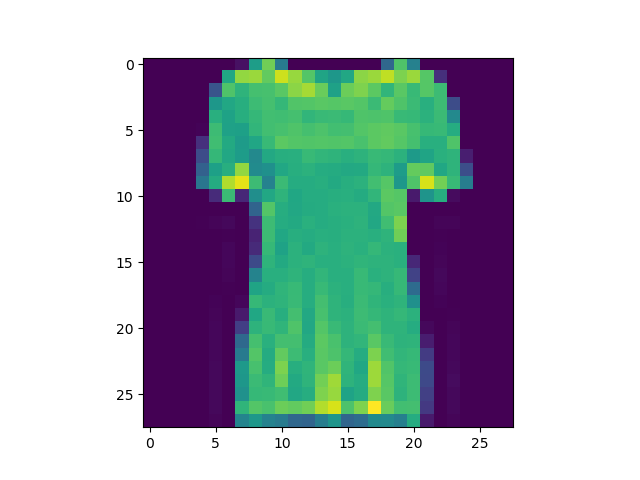

In [6]:
# Visualize an image. To visualize a different image, set the index to any value between 0 and 59999
img_index=10

# Display an image from the data set
label_index = y_train[img_index]
plt.imshow(x_train[img_index])
print('Label Index: ' + str(label_index) + " Fashion Labels: " + (fashion_mnist_labels[label_index]))
display()

The data set is loaded into memory and will be normalized so the pixel values in each image range between 0-1 insteaed of 0-255 pixel.   This will help the model converge faster because it is working with smaller numbers.

In this section we also one-hot encode the labels for each image.  This is done so the model does not treat the label (fashion category) with an implied numeric ranking.  For instance, T-Shirts are label '0' and Sneakers are label '7'. We don't want the model to interpret these values with any numeric ranking. An array will be created and each image will be represented in the array with a '1' corresponding to its label. For instance, an image with an array that looks like this: array([0,0,0,0,0,0,0,0,0,1]) means the image label corresponds to the 9th index which is 'ankle boots'.

In [8]:
# Set number of categories
num_classes = 10

# Set image size to 28*28 pixels
img_rows,img_cols = 28,28

# Reshape the array without changing the data.  
# Parameters = number of elements in the input array, the new shape (28*28), and the order 
x_train = x_train.reshape(60000, img_rows, img_cols, 1)
x_test = x_test.reshape(10000, img_rows, img_cols, 1)

#Type convert and scale the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# One-hot encoding of images
# This creates an array equal to the number of labels (fashion categories).  Each image
# is represented in the vector with a 1 corresponding to it's label.  
# For instance, an image with an array that looks like this: array([0,0,0,0,0,0,0,0,0,1]) means the image
# participates in the 10th category which is 'ankle boots'

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


Now we are able to define the Convolutional Neural Network (CNN) in layers

![CNN](https://raw.githubusercontent.com/amynic/azureml-sdk-fashion/master/images/cnn.JPG "CNN")

* This is a **sequential model** meaning every layer passes information forward to the next layer of the network
* **1st Convoltuional Layer** - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **2nd pooling layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **3rd Convolutional Layer ** -we add a Convoltuional Layer - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **4th Pooling Layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **5th/6th Dense fully connected layer with softmax function:** put features together and classify what item of clothing is used

Use the Keras API to define the architecture.  Initially we will use the sequential API and compile the model with a common algorithm and loss metric

After running through the experiment, come back to this section and change some of the parameters, re-run the code, and see how the accuracy and model will change.   Consider changing:
  Add a drop out layer after the first pooling layer and also before the final dense layer:  model.add(Dropout(0.5))
  Change the value of the dropout between 0 and 1:  model.add(Dropout(X))
  Change the 2 Conv2D layer first variable to 32 instead of 64:  model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))
  Add padding to each of the Conv2D layers: model.add(Conv2D(32, kernel_size=(3,3), padding = 'same', activation = 'relu'))

In [11]:
#First, set some parameters

# Batch size is the sample size that will be processed independently, in parallel
batch_size =256

# The number of training passes
epochs = 10

input_shape = (img_rows, img_cols, 1)


#Define the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
conv2d_4 (Conv2D) (None, 26, 26, 32) 320 
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32) 0 
_________________________________________________________________
dropout_5 (Dropout) (None, 13, 13, 32) 0 
_________________________________________________________________
conv2d_5 (Conv2D) (None, 11, 11, 32) 9248 
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32) 0 
_________________________________________________________________
dropout_6 (Dropout) (None, 5, 5, 32) 0 
_________________________________________________________________
conv2d_6 (Conv2D) (None, 3, 3, 32) 9248 
_________________________________________________________________
dropout_7 (Dropout) (None, 3, 3, 32) 0 
_________________________________________________________________
flatten_2 (Flatten) (None, 288) 0 
_________________________________________________________________
dense_3 (Dense) (None, 32) 9248 
_________________________________________________________________
dropout_8 (Dropout) (None, 32) 0 
_________________________________________________________________
dense_4 (Dense) (None, 10) 330 
=================================================================
Total params: 28,394
Trainable params: 28,394
Non-trainable params: 0
_________________________________________________________________

Training the model is as simple as using the fit() method in Keras.   This code compiles the CNN model and assigns a loss/optimiser function and identifies the output metrics to view  

A timer is started to show how long the model takes to run.
The model is trained using the epoch and batch_size parameters defined earlier. The test data set is passed in as the validation set so we can see how the accuracy differs between the training set and the validation set.

The opimizer is set to softmax but the value can be changed.  Here are some other options:  https://keras.io/optimizers/

In [13]:
# Train the model and return loss and accuracy for each epoch/training iteration
start = time.time()
hist = model.fit(x_train, y_train, 
                  batch_size=batch_size, 
                  epochs=epochs, verbose=1)
end = time.time()

Error while obtaining a new communication channel

In [14]:
# Print how long it took to train the  model
print('Time to train model (sec): ', (end-start))

Pass in the test data (x_test and y_test) to the evaluate method and Keras will score the model.

In [16]:
#evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

In [17]:
# Plot model accuracy across the epochs 

accuracy = hist.history['acc']
#print(accuracy)
#validation_accuracy = hist.history['val_acc']

epochs = range(len(accuracy))

fig = plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

display(fig)

In [18]:
# Plot model loss across the epochs

loss = hist.history['loss']
#validation_loss = hist.history['val_loss']

fig = plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

display(fig)

In [19]:
# Run this code to see if the labels for each of the 15 images was predicted correctly
predictions = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(predictions[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
#Visualize in databricks
display()

To easily see the impact of changing the activation function, a python function is defined below to construct, compile, train, and score a model.   The code below is taken from earlier cells.

In [21]:
def runCNN(activation, verbose):

  img_rows, img_cols = 28, 28
  input_shape = (img_rows, img_cols, 1)
  epochs = 1
  
  # Building up our CNN
  model = Sequential()
  
  # Convolution Layer
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activation,
                 kernel_initializer='he_normal',
                 input_shape = input_shape)) 
  
  # Pooling with stride (2, 2)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Randomly delete 25% of neurons to avoid overfitting  
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), activation=activation))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(32, (3, 3), activation=activation))
  model.add(Dropout(0.4))
  
  # Flatten layer 
  model.add(Flatten())
  
  # Fully connected Layer
  model.add(Dense(32, activation=activation))
  
  # Randomely delete neurons to avoid overfitting 
  model.add(Dropout(0.3))
  
  # Apply Softmax
  model.add(Dense(num_classes, activation='softmax'))

  # Loss function (crossentropy) and Optimizer (Adam)
  model.compile(loss = losses.categorical_crossentropy,
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])
 
  # Train model
  model.fit(x_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, verbose=0)

  # Evaluate our model
  score = model.evaluate(x_test, y_test, verbose=0)
  
  # Return
  return score

In [22]:
# Signmoid activation  

score_sigmoid = runCNN('sigmoid', 0)
print('Sigmoid, Test loss:', score_sigmoid[0])
print('Sigmoid, Test accuracy:', score_sigmoid[1])


In [23]:
# Tanh activation

score_tanh = runCNN('tanh', 0)
print('tanh, Test loss:', score_tanh[0])
print('tanh, Test accuracy:', score_tanh[1])


In [24]:
# Relu activation

score_sigmoid = runCNN('sigmoid', 0)
print('Sigmoid, Test loss:', score_sigmoid[0])
print('Sigmoid, Test accuracy:', score_sigmoid[1])
